# Agent Memory: Building Memory-Enabled Agents with LangGraph

In this notebook, we'll explore **agent memory systems** - the ability for AI agents to remember information across interactions. We'll implement all five memory types from the **CoALA (Cognitive Architectures for Language Agents)** framework while building on our Personal Wellness Assistant use case.

**Learning Objectives:**
- Understand the 5 memory types from the CoALA framework
- Implement short-term memory with checkpointers and thread_id
- Build long-term memory with InMemoryStore and namespaces
- Use semantic memory for meaning-based retrieval
- Apply episodic memory for few-shot learning from past experiences
- Create procedural memory for self-improving agents
- Combine all memory types into a unified wellness agent

## Table of Contents:

- **Breakout Room #1:** Memory Foundations
  - Task 1: Dependencies
  - Task 2: Understanding Agent Memory (CoALA Framework)
  - Task 3: Short-Term Memory (MemorySaver, thread_id)
  - Task 4: Long-Term Memory (InMemoryStore, namespaces)
  - Task 5: Message Trimming & Context Management
  - Question #1 & Question #2
  - 🏗️ Activity #1: Store & Retrieve User Wellness Profile

- **Breakout Room #2:** Advanced Memory & Integration
  - Task 6: Semantic Memory (Embeddings + Search)
  - Task 7: Building Semantic Wellness Knowledge Base
  - Task 8: Episodic Memory (Few-Shot Learning)
  - Task 9: Procedural Memory (Self-Improving Agent)
  - Task 10: Unified Wellness Memory Agent
  - Question #3 & Question #4
  - 🏗️ Activity #2: Wellness Memory Dashboard

---
# 🤝 Breakout Room #1
## Memory Foundations

## Task 1: Dependencies

Before we begin, make sure you have:

1. **API Keys** for:
   - OpenAI (for GPT-4o-mini and embeddings)
   - LangSmith (optional, for tracing)

2. **Dependencies installed** via `uv sync`

In [1]:
# Core imports
import os
import getpass
from enum import Enum
from uuid import uuid4
from typing import Annotated, TypedDict

import nest_asyncio
nest_asyncio.apply()  # Required for async operations in Jupyter

import sys
sys.executable



'/Users/dereky/old/personal/code/ai-makerspace-code/AIE9/06_Agent_Memory/.venv/bin/python'

In [2]:
# Set API Keys
import os
import openai
from getpass import getpass
from dotenv import load_dotenv
load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")
# openai.api_key = getpass("OpenAI API Key: ")
os.environ["OPENAI_API_KEY"] = openai.api_key
#print("API Key: ", os.environ["OPENAI_API_KEY"])
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
# Optional: LangSmith for tracing
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIE10 - Memory - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")

if not os.environ["LANGCHAIN_API_KEY"]:
    os.environ["LANGCHAIN_TRACING_V2"] = "false"
    print("LangSmith tracing disabled")
else:
    print(f"LangSmith tracing enabled. Project: {os.environ['LANGCHAIN_PROJECT']}")

LangSmith tracing enabled. Project: AIE10 - Memory - 1d674949


In [3]:
import sys, site
print("Python:", sys.executable)
print("Site-packages:", site.getsitepackages() if hasattr(site, "getsitepackages") else "n/a")


Python: /Users/dereky/old/personal/code/ai-makerspace-code/AIE9/06_Agent_Memory/.venv/bin/python
Site-packages: ['/Users/dereky/old/personal/code/ai-makerspace-code/AIE9/06_Agent_Memory/.venv/lib/python3.11/site-packages']


In [4]:
# # Optional: LangSmith for tracing
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_PROJECT"] = f"AIE9 - Agent Memory - {uuid4().hex[0:8]}"
# os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key (press Enter to skip): ") or ""

# if not os.environ["LANGCHAIN_API_KEY"]:
#     os.environ["LANGCHAIN_TRACING_V2"] = "false"
#     print("LangSmith tracing disabled")
# else:
#     print(f"LangSmith tracing enabled. Project: {os.environ['LANGCHAIN_PROJECT']}")

In [5]:
# Initialize LLM
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Test the connection
response = llm.invoke("Say 'Memory systems ready!' in exactly those words.")
print(response.content)

Memory systems ready!


## Task 2: Understanding Agent Memory (CoALA Framework)

The **CoALA (Cognitive Architectures for Language Agents)** framework identifies 5 types of memory that agents can use:

| Memory Type | Human Analogy | AI Implementation | Wellness Example |
|-------------|---------------|-------------------|------------------|
| **Short-term** | What someone just said | Conversation history within a thread | Current consultation conversation |
| **Long-term** | Remembering a friend's birthday | User preferences stored across sessions | User's goals, allergies, conditions |
| **Semantic** | Knowing Paris is in France | Facts retrieved by meaning | Wellness knowledge retrieval |
| **Episodic** | Remembering your first day at work | Learning from past experiences | Past successful advice patterns |
| **Procedural** | Knowing how to ride a bike | Self-improving instructions | Learned communication preferences |

### Memory Architecture Overview

```
┌─────────────────────────────────────────────────────────────────┐
│                    LangGraph Wellness Agent                     │
├─────────────────────────────────────────────────────────────────┤
│                                                                 │
│  ┌──────────────┐  ┌──────────────┐  ┌──────────────┐           │
│  │  Short-term  │  │  Long-term   │  │   Semantic   │           │
│  │    Memory    │  │    Memory    │  │    Memory    │           │
│  │              │  │              │  │              │           │
│  │ Checkpointer │  │    Store     │  │Store+Embed   │           │
│  │ + thread_id  │  │ + namespace  │  │  + search()  │           │
│  └──────────────┘  └──────────────┘  └──────────────┘           │
│                                                                 │
│  ┌──────────────┐  ┌──────────────┐                             │
│  │   Episodic   │  │  Procedural  │                             │
│  │    Memory    │  │    Memory    │                             │
│  │              │  │              │                             │
│  │  Few-shot    │  │Self-modifying│                             │
│  │  examples    │  │   prompts    │                             │
│  └──────────────┘  └──────────────┘                             │
│                                                                 │
└─────────────────────────────────────────────────────────────────┘
```

### Key LangGraph Components

| Component | Memory Type | Scope |
|-----------|-------------|-------|
| `MemorySaver` (Checkpointer) | Short-term | Within a single thread |
| `InMemoryStore` | Long-term, Semantic, Episodic, Procedural | Across all threads |
| `thread_id` | Short-term | Identifies unique conversations |
| Namespaces | All store-based | Organizes memories by user/purpose |

**Documentation:**
- [CoALA Paper](https://arxiv.org/abs/2309.02427)
- [LangGraph Memory Concepts](https://langchain-ai.github.io/langgraph/concepts/memory/)

## Task 3: Short-Term Memory (MemorySaver, thread_id)

**Short-term memory** maintains context within a single conversation thread. Think of it like your working memory during a phone call - you remember what was said earlier, but once the call ends, those details fade.

In LangGraph, short-term memory is implemented through:
- **Checkpointer**: Saves the graph state at each step
- **thread_id**: Uniquely identifies each conversation

### How It Works

```
Thread 1: "Hi, I'm Alice"          Thread 2: "What's my name?"
     │                                   │
     ▼                                   ▼
┌──────────────┐                   ┌──────────────┐
│ Checkpointer │                   │ Checkpointer │
│  thread_1    │                   │  thread_2    │
│              │                   │              │
│ ["Hi Alice"] │                   │ [empty]      │
└──────────────┘                   └──────────────┘
     │                                   │
     ▼                                   ▼
"Hi Alice!"                        "I don't know your name"
```

In [6]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

# Define the state schema for our graph
# The `add_messages` annotation tells LangGraph how to update the messages list
class State(TypedDict):
    messages: Annotated[list, add_messages]


# Define our wellness chatbot node
def wellness_chatbot(state: State):
    """Process the conversation and generate a wellness-focused response."""
    system_prompt = SystemMessage(content="""You are a friendly Personal Wellness Assistant. 
Help users with exercise, nutrition, sleep, and stress management questions.
Be supportive and remember details the user shares about themselves.""")
    
    messages = [system_prompt] + state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}


# Build the graph
builder = StateGraph(State)
builder.add_node("chatbot", wellness_chatbot)
builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

# Compile with a checkpointer for short-term memory
checkpointer = MemorySaver()
wellness_graph = builder.compile(checkpointer=checkpointer)

print("Wellness chatbot compiled with short-term memory (checkpointing)")

Wellness chatbot compiled with short-term memory (checkpointing)


In [7]:
# Test short-term memory within a thread
config = {"configurable": {"thread_id": "wellness_thread_1"}}

# First message - introduce ourselves
response = wellness_graph.invoke(
    {"messages": [HumanMessage(content="Hi! My name is Sarah and I want to improve my sleep.")]},
    config
)
print("User: Hi! My name is Sarah and I want to improve my sleep.")
print(f"Assistant: {response['messages'][-1].content}")
print()

User: Hi! My name is Sarah and I want to improve my sleep.
Assistant: Hi Sarah! It's great to meet you! Improving sleep is such an important goal for overall wellness. Can you share a bit about your current sleep routine or any specific challenges you're facing with sleep? This will help me provide you with tailored advice!



In [8]:
# Second message - test if it remembers (same thread)
response = wellness_graph.invoke(
    {"messages": [HumanMessage(content="What's my name and what am I trying to improve?")]},
    config  # Same config = same thread_id
)
print("User: What's my name and what am I trying to improve?")
print(f"Assistant: {response['messages'][-1].content}")

User: What's my name and what am I trying to improve?
Assistant: Your name is Sarah, and you're looking to improve your sleep. How can I assist you further with that?


In [9]:
# New thread - it won't remember Sarah!
different_config = {"configurable": {"thread_id": "wellness_thread_2"}}

response = wellness_graph.invoke(
    {"messages": [HumanMessage(content="What's my name?")]},
    different_config  # Different thread_id = no memory of Sarah
)
print("User (NEW thread): What's my name?")
print(f"Assistant: {response['messages'][-1].content}")
print()
print("Notice: The agent doesn't know our name because this is a new thread!")

User (NEW thread): What's my name?
Assistant: I don't have your name yet! If you'd like to share it, I can remember it for our future conversations. How can I assist you today?

Notice: The agent doesn't know our name because this is a new thread!


In [10]:
# Inspect the state of thread 1
state = wellness_graph.get_state(config)
print(f"Thread 1 has {len(state.values['messages'])} messages:")
for msg in state.values['messages']:
    role = "User" if isinstance(msg, HumanMessage) else "Assistant"
    content = msg.content[:80] + "..." if len(msg.content) > 80 else msg.content
    print(f"  {role}: {content}")

Thread 1 has 4 messages:
  User: Hi! My name is Sarah and I want to improve my sleep.
  Assistant: Hi Sarah! It's great to meet you! Improving sleep is such an important goal for ...
  User: What's my name and what am I trying to improve?
  Assistant: Your name is Sarah, and you're looking to improve your sleep. How can I assist y...


## Task 4: Long-Term Memory (InMemoryStore, namespaces)

**Long-term memory** stores information across different conversation threads. This is like remembering that your friend prefers tea over coffee - you remember it every time you meet them, regardless of what you're currently discussing.

In LangGraph, long-term memory uses:
- **Store**: A persistent key-value store
- **Namespaces**: Organize memories by user, application, or context

### Key Difference from Short-Term Memory

| Short-Term (Checkpointer) | Long-Term (Store) |
|---------------------------|-------------------|
| Scoped to a single thread | Shared across all threads |
| Automatic (messages) | Explicit (you decide what to store) |
| Conversation history | User preferences, facts, etc. |

In [11]:
from langgraph.store.memory import InMemoryStore

# Create a store for long-term memory
store = InMemoryStore()

# Namespaces organize memories - typically by user_id and category
user_id = "user_sarah"
profile_namespace = (user_id, "profile")
preferences_namespace = (user_id, "preferences")

# Store Sarah's wellness profile
store.put(profile_namespace, "name", {"value": "Sarah"})
store.put(profile_namespace, "goals", {"primary": "improve sleep", "secondary": "reduce stress"})
store.put(profile_namespace, "conditions", {"allergies": ["peanuts"], "injuries": ["bad knee"]})

# Store Sarah's preferences
store.put(preferences_namespace, "communication", {"style": "friendly", "detail_level": "moderate"})
store.put(preferences_namespace, "schedule", {"preferred_workout_time": "morning", "available_days": ["Mon", "Wed", "Fri"]})

print("Stored Sarah's profile and preferences in long-term memory")

Stored Sarah's profile and preferences in long-term memory


In [12]:
# Retrieve specific memories
name = store.get(profile_namespace, "name")
print(f"Name: {name.value}")

goals = store.get(profile_namespace, "goals")
print(f"Goals: {goals.value}")

# List all memories in a namespace
print("\nAll profile items:")
for item in store.search(profile_namespace):
    print(f"  {item.key}: {item.value}")

Name: {'value': 'Sarah'}
Goals: {'primary': 'improve sleep', 'secondary': 'reduce stress'}

All profile items:
  name: {'value': 'Sarah'}
  goals: {'primary': 'improve sleep', 'secondary': 'reduce stress'}
  conditions: {'allergies': ['peanuts'], 'injuries': ['bad knee']}


In [13]:
from langgraph.store.base import BaseStore
from langchain_core.runnables import RunnableConfig

# Define state with user_id for personalization
class PersonalizedState(TypedDict):
    messages: Annotated[list, add_messages]
    user_id: str


def personalized_wellness_chatbot(state: PersonalizedState, config: RunnableConfig, *, store: BaseStore):
    """A wellness chatbot that uses long-term memory for personalization."""
    user_id = state["user_id"]
    profile_namespace = (user_id, "profile")
    preferences_namespace = (user_id, "preferences")
    
    # Retrieve user profile from long-term memory
    profile_items = list(store.search(profile_namespace))
    pref_items = list(store.search(preferences_namespace))
    
    # Build context from profile
    profile_text = "\n".join([f"- {p.key}: {p.value}" for p in profile_items])
    pref_text = "\n".join([f"- {p.key}: {p.value}" for p in pref_items])
    
    system_msg = f"""You are a Personal Wellness Assistant. You know the following about this user:

PROFILE:
{profile_text if profile_text else 'No profile stored.'}

PREFERENCES:
{pref_text if pref_text else 'No preferences stored.'}

Use this information to personalize your responses. Be supportive and helpful."""
    
    messages = [SystemMessage(content=system_msg)] + state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}


# Build the personalized graph
builder2 = StateGraph(PersonalizedState)
builder2.add_node("chatbot", personalized_wellness_chatbot)
builder2.add_edge(START, "chatbot")
builder2.add_edge("chatbot", END)

# Compile with BOTH checkpointer (short-term) AND store (long-term)
personalized_graph = builder2.compile(
    checkpointer=MemorySaver(),
    store=store
)

print("Personalized graph compiled with both short-term and long-term memory")

Personalized graph compiled with both short-term and long-term memory


In [14]:
# Test the personalized chatbot - it knows Sarah's profile!
config = {"configurable": {"thread_id": "personalized_thread_1"}}

response = personalized_graph.invoke(
    {
        "messages": [HumanMessage(content="What exercises would you recommend for me?")],
        "user_id": "user_sarah"
    },
    config
)

print("User: What exercises would you recommend for me?")
print(f"Assistant: {response['messages'][-1].content}")
print()
print("Notice: The agent knows about Sarah's bad knee without her mentioning it!")

User: What exercises would you recommend for me?
Assistant: Hi Sarah! It's great that you're looking to improve your sleep and reduce stress through exercise. Given your bad knee, we want to focus on low-impact activities that are gentle on your joints. Here are some exercises you might enjoy:

1. **Walking**: A simple and effective way to get moving. Try to walk in the morning when you feel fresh. You can start with short distances and gradually increase as you feel comfortable.

2. **Swimming**: This is a fantastic low-impact workout that can help you relax and improve your overall fitness without putting stress on your knee.

3. **Yoga**: Gentle yoga can be excellent for reducing stress and improving flexibility. Look for classes that focus on restorative or gentle yoga, which can also help with sleep.

4. **Cycling**: If you have access to a stationary bike or can ride a bike on flat surfaces, this can be a great way to get your heart rate up without straining your knee.

5. **Pila

In [15]:
# Even in a NEW thread, it still knows Sarah's profile
# because long-term memory is cross-thread!

new_config = {"configurable": {"thread_id": "personalized_thread_2"}}

response = personalized_graph.invoke(
    {
        "messages": [HumanMessage(content="Can you suggest a snack for me?")],
        "user_id": "user_sarah"
    },
    new_config
)

print("User (NEW thread): Can you suggest a snack for me?")
print(f"Assistant: {response['messages'][-1].content}")
print()
print("Notice: Even in a new thread, the agent knows Sarah has a peanut allergy!")

User (NEW thread): Can you suggest a snack for me?
Assistant: Absolutely, Sarah! Since you have a peanut allergy, let’s find a tasty and safe snack for you. How about some apple slices with almond butter? It’s a great combination of fiber and healthy fats, which can help keep you satisfied. Just make sure to check that the almond butter is made in a peanut-free facility to avoid any cross-contamination. 

If you’re looking for something lighter, you could also try Greek yogurt with some berries. It’s delicious and packed with protein, which can be great for your overall wellness. Let me know if you’d like more options!

Notice: Even in a new thread, the agent knows Sarah has a peanut allergy!


## Task 5: Message Trimming & Context Management

Long conversations can exceed the LLM's context window. LangGraph provides utilities to manage message history:

- **`trim_messages`**: Keeps only recent messages up to a token limit
- **Summarization**: Compress older messages into summaries

### Why Trim Even with 128K Context?

Even with large context windows:
1. **Cost**: More tokens = higher API costs
2. **Latency**: Larger contexts take longer to process
3. **Quality**: Models can struggle with "lost in the middle" - important info buried in long contexts
4. **Relevance**: Old messages may not be relevant to current query

In [16]:
from langchain_core.messages import trim_messages

# Create a trimmer that keeps only recent messages
trimmer = trim_messages(
    max_tokens=500,  # Keep messages up to this token count
    strategy="last",  # Keep the most recent messages
    token_counter=llm,  # Use the LLM to count tokens
    include_system=True,  # Always keep system messages
    allow_partial=False,  # Don't cut messages in half
)

# Example: Create a long conversation
long_conversation = [
    SystemMessage(content="You are a wellness assistant."),
    HumanMessage(content="I want to improve my health."),
    AIMessage(content="Great goal! Let's start with exercise. What's your current activity level?"),
    HumanMessage(content="I walk about 30 minutes a day."),
    AIMessage(content="That's a good foundation. For cardiovascular health, aim for 150 minutes of moderate activity per week."),
    HumanMessage(content="What about nutrition?"),
    AIMessage(content="Focus on whole foods: vegetables, lean proteins, whole grains. Limit processed foods and added sugars."),
    HumanMessage(content="And sleep?"),
    AIMessage(content="Aim for 7-9 hours. Maintain a consistent sleep schedule and create a relaxing bedtime routine."),
    HumanMessage(content="What's the most important change I should make first?"),
]

# Trim to fit context window
trimmed = trimmer.invoke(long_conversation)
print(f"Original: {len(long_conversation)} messages")
print(f"Trimmed: {len(trimmed)} messages")
print("\nTrimmed conversation:")
for msg in trimmed:
    role = type(msg).__name__.replace("Message", "")
    content = msg.content[:60] + "..." if len(msg.content) > 60 else msg.content
    print(f"  {role}: {content}")

Original: 10 messages
Trimmed: 10 messages

Trimmed conversation:
  System: You are a wellness assistant.
  Human: I want to improve my health.
  AI: Great goal! Let's start with exercise. What's your current a...
  Human: I walk about 30 minutes a day.
  AI: That's a good foundation. For cardiovascular health, aim for...
  Human: What about nutrition?
  AI: Focus on whole foods: vegetables, lean proteins, whole grain...
  Human: And sleep?
  AI: Aim for 7-9 hours. Maintain a consistent sleep schedule and ...
  Human: What's the most important change I should make first?


In [17]:
# Summarization approach for longer conversations

def summarize_conversation(messages: list, max_messages: int = 6) -> list:
    """Summarize older messages to manage context length."""
    if len(messages) <= max_messages:
        return messages
    
    # Keep the system message and last few messages
    system_msg = messages[0] if isinstance(messages[0], SystemMessage) else None
    content_messages = messages[1:] if system_msg else messages
    
    if len(content_messages) <= max_messages:
        return messages
    
    old_messages = content_messages[:-max_messages+1]
    recent_messages = content_messages[-max_messages+1:]
    
    # Summarize old messages
    summary_prompt = f"""Summarize this conversation in 2-3 sentences, 
capturing key wellness topics discussed and any important user information:

{chr(10).join([f'{type(m).__name__}: {m.content[:200]}' for m in old_messages])}"""
    
    summary = llm.invoke(summary_prompt)
    
    # Return: system + summary + recent messages
    result = []
    if system_msg:
        result.append(system_msg)
    result.append(SystemMessage(content=f"[Previous conversation summary: {summary.content}]"))
    result.extend(recent_messages)
    
    return result


# Test summarization
summarized = summarize_conversation(long_conversation, max_messages=4)
print(f"Summarized: {len(summarized)} messages")
print("\nSummarized conversation:")
for msg in summarized:
    role = type(msg).__name__.replace("Message", "")
    content = msg.content[:80] + "..." if len(msg.content) > 80 else msg.content
    print(f"  {role}: {content}")

Summarized: 5 messages

Summarized conversation:
  System: You are a wellness assistant.
  System: [Previous conversation summary: The conversation centers on the user's desire to...
  Human: And sleep?
  AI: Aim for 7-9 hours. Maintain a consistent sleep schedule and create a relaxing be...
  Human: What's the most important change I should make first?


---
## ❓ Question #1:

What are the trade-offs between **short-term memory** (checkpointer) vs **long-term memory** (store)? When should wellness data move from short-term to long-term?

Consider:
- What information should persist across sessions?
- What are the privacy implications of each?
- How would you decide what to promote from short-term to long-term?

##### Answer:
*Your answer here*

## ❓ Question #2:

Why use message trimming with a 128K context window when HealthWellnessGuide.txt is only ~16KB? What should **always** be preserved when trimming a wellness consultation?

Consider:
- The "lost in the middle" phenomenon
- Cost and latency implications
- What user information is critical for safety (allergies, conditions, etc.)

##### Answer:
*Your answer here*

---
## 🏗️ Activity #1: Store & Retrieve User Wellness Profile

Build a complete wellness profile system that:
1. Defines a wellness profile schema (name, goals, conditions, preferences)
2. Creates functions to store and retrieve profile data
3. Builds a personalized wellness agent that uses the profile
4. Tests that different users get different advice

### Requirements:
- Define at least 5 profile attributes
- Support multiple users with different profiles
- Agent should reference profile data in responses

In [18]:
### YOUR CODE HERE ###

# Step 1: Define a wellness profile schema
# Example attributes: name, age, goals, conditions, allergies, fitness_level, preferred_activities


# Step 2: Create helper functions to store and retrieve profiles
def store_wellness_profile(store, user_id: str, profile: dict):
    """Store a user's wellness profile."""
    pass


def get_wellness_profile(store, user_id: str) -> dict:
    """Retrieve a user's wellness profile."""
    pass


# Step 3: Create two different user profiles


# Step 4: Build a personalized agent that uses profiles


# Step 5: Test with different users - they should get different advice


---
# 🤝 Breakout Room #2
## Advanced Memory & Integration

## Task 6: Semantic Memory (Embeddings + Search)

**Semantic memory** stores facts and retrieves them based on *meaning* rather than exact matches. This is like how you might remember "that restaurant with the great pasta" even if you can't remember its exact name.

In LangGraph, semantic memory uses:
- **Store with embeddings**: Converts text to vectors for similarity search
- **`store.search()`**: Finds relevant memories by semantic similarity

### How It Works

```
User asks: "What helps with headaches?"
         ↓
Query embedded → [0.2, 0.8, 0.1, ...]
         ↓
Compare with stored wellness facts:
  - "Hydration can relieve headaches" → 0.92 similarity ✓
  - "Exercise improves sleep" → 0.35 similarity
         ↓
Return: "Hydration can relieve headaches"
```

In [19]:
from langchain_openai import OpenAIEmbeddings

# Create embeddings model
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Create a store with semantic search enabled
semantic_store = InMemoryStore(
    index={
        "embed": embeddings,
        "dims": 1536,  # Dimension of text-embedding-3-small
    }
)

print("Semantic memory store created with embedding support")

Semantic memory store created with embedding support


In [20]:
# Store various wellness facts as semantic memories
namespace = ("wellness", "facts")

wellness_facts = [
    ("fact_1", {"text": "Drinking water can help relieve headaches caused by dehydration"}),
    ("fact_2", {"text": "Regular exercise improves sleep quality and helps you fall asleep faster"}),
    ("fact_3", {"text": "Deep breathing exercises can reduce stress and anxiety within minutes"}),
    ("fact_4", {"text": "Eating protein at breakfast helps maintain steady energy levels throughout the day"}),
    ("fact_5", {"text": "Blue light from screens can disrupt your circadian rhythm and sleep"}),
    ("fact_6", {"text": "Walking for 30 minutes daily can improve cardiovascular health"}),
    ("fact_7", {"text": "Magnesium-rich foods like nuts and leafy greens can help with muscle cramps"}),
    ("fact_8", {"text": "A consistent sleep schedule, even on weekends, improves overall sleep quality"}),
]

for key, value in wellness_facts:
    semantic_store.put(namespace, key, value)

print(f"Stored {len(wellness_facts)} wellness facts in semantic memory")

Stored 8 wellness facts in semantic memory


In [21]:
# Search semantically - notice we don't need exact matches!

queries = [
    "My head hurts, what should I do?",
    "How can I get better rest at night?",
    "I'm feeling stressed and anxious",
    "What should I eat in the morning?",
]

for query in queries:
    print(f"\nQuery: {query}")
    results = semantic_store.search(namespace, query=query, limit=2)
    for r in results:
        print(f"   {r.value['text']} (score: {r.score:.3f})")


Query: My head hurts, what should I do?
   Drinking water can help relieve headaches caused by dehydration (score: 0.327)
   Magnesium-rich foods like nuts and leafy greens can help with muscle cramps (score: 0.173)

Query: How can I get better rest at night?
   Regular exercise improves sleep quality and helps you fall asleep faster (score: 0.463)
   A consistent sleep schedule, even on weekends, improves overall sleep quality (score: 0.426)

Query: I'm feeling stressed and anxious
   Deep breathing exercises can reduce stress and anxiety within minutes (score: 0.415)
   Drinking water can help relieve headaches caused by dehydration (score: 0.224)

Query: What should I eat in the morning?
   Eating protein at breakfast helps maintain steady energy levels throughout the day (score: 0.467)
   Walking for 30 minutes daily can improve cardiovascular health (score: 0.249)


## Task 7: Building Semantic Wellness Knowledge Base

Let's load the HealthWellnessGuide.txt and create a semantic knowledge base that our agent can search.

This is similar to RAG from Session 4, but now using LangGraph's Store API instead of a separate vector database.

In [22]:
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Load and chunk the wellness document
loader = TextLoader("data/HealthWellnessGuide.txt")
documents = loader.load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100
)
chunks = text_splitter.split_documents(documents)

print(f"Loaded and split into {len(chunks)} chunks")
print(f"\nSample chunk:\n{chunks[0].page_content[:200]}...")

Loaded and split into 45 chunks

Sample chunk:
The Personal Wellness Guide
A Comprehensive Resource for Health and Well-being

PART 1: EXERCISE AND MOVEMENT

Chapter 1: Understanding Exercise Basics

Exercise is one of the most important things yo...


In [23]:
# Store chunks in semantic memory
knowledge_namespace = ("wellness", "knowledge")

for i, chunk in enumerate(chunks):
    semantic_store.put(
        knowledge_namespace,
        f"chunk_{i}",
        {"text": chunk.page_content, "source": "HealthWellnessGuide.txt"}
    )

print(f"Stored {len(chunks)} chunks in semantic knowledge base")

Stored 45 chunks in semantic knowledge base


In [24]:
# Build a semantic search wellness chatbot

class SemanticState(TypedDict):
    messages: Annotated[list, add_messages]
    user_id: str


def semantic_wellness_chatbot(state: SemanticState, config: RunnableConfig, *, store: BaseStore):
    """A wellness chatbot that retrieves relevant facts using semantic search."""
    user_message = state["messages"][-1].content
    
    # Search for relevant knowledge
    knowledge_results = store.search(
        ("wellness", "knowledge"),
        query=user_message,
        limit=3
    )
    
    # Build context from retrieved knowledge
    if knowledge_results:
        knowledge_text = "\n\n".join([f"- {r.value['text']}" for r in knowledge_results])
        system_msg = f"""You are a Personal Wellness Assistant with access to a wellness knowledge base.

Relevant information from your knowledge base:
{knowledge_text}

Use this information to answer the user's question. If the information doesn't directly answer their question, use your general knowledge but mention what you found."""
    else:
        system_msg = "You are a Personal Wellness Assistant. Answer wellness questions helpfully."
    
    messages = [SystemMessage(content=system_msg)] + state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}


# Build and compile
builder3 = StateGraph(SemanticState)
builder3.add_node("chatbot", semantic_wellness_chatbot)
builder3.add_edge(START, "chatbot")
builder3.add_edge("chatbot", END)

semantic_graph = builder3.compile(
    checkpointer=MemorySaver(),
    store=semantic_store
)

print("Semantic wellness chatbot ready")

Semantic wellness chatbot ready


In [25]:
# Test semantic retrieval
config = {"configurable": {"thread_id": "semantic_thread_1"}}

questions = [
    "What exercises can help with lower back pain?",
    "How can I improve my sleep quality?",
    "What should I eat for better gut health?",
]

for q in questions:
    response = semantic_graph.invoke(
        {"messages": [HumanMessage(content=q)], "user_id": "test_user"},
        config
    )
    print(f"\nUser: {q}")
    print(f"Assistant: {response['messages'][-1].content[:500]}...")


User: What exercises can help with lower back pain?
Assistant: There are several effective exercises that can help alleviate lower back pain. Here are some recommended ones:

1. **Cat-Cow Stretch**: Start on your hands and knees. Alternate between arching your back up (like a cat) and letting it sag down (like a cow). Perform 10-15 repetitions.

2. **Bird Dog**: From a hands and knees position, extend your opposite arm and leg while keeping your core engaged. Hold for 5 seconds, then switch sides. Aim for 10 repetitions per side.

3. **Partial Crunches**: L...

User: How can I improve my sleep quality?
Assistant: Improving your sleep quality can be achieved through several essential sleep hygiene practices and creating an optimal sleep environment. Here are some tips:

### Sleep Hygiene Practices:
1. **Maintain a Consistent Sleep Schedule**: Go to bed and wake up at the same time every day, even on weekends.
2. **Create a Relaxing Bedtime Routine**: Engage in calming activities before

## Task 8: Episodic Memory (Few-Shot Learning)

**Episodic memory** stores past experiences and uses them as examples for future tasks. In humans, this is like remembering the first time you successfully gave someone good advice and using that experience to guide future interactions.

For AI agents, episodic memory is often implemented as **few-shot examples** - showing the model examples of correct behavior so it can learn patterns.

### The CoALA Framework Perspective

> "Facts can be written to semantic memory, whereas **experiences** can be written to episodic memory."

Key insight: Sometimes it's easier to **show** than **tell**. LLMs learn well from examples!

In [26]:
# Create episodic memory with past successful interactions
episodic_namespace = ("agent", "episodes")

successful_episodes = [
    {
        "situation": "User asked about starting exercise with joint pain",
        "input": "I want to start exercising but my knees hurt. What should I do?",
        "output": """For knee-friendly exercise, I'd recommend starting with low-impact activities:

1. **Swimming or water aerobics** - Water supports your joints while providing great cardio
2. **Cycling** - Either stationary or regular bikes are gentle on knees
3. **Elliptical machine** - Provides cardio without impact

Start slowly with 15-20 minutes and gradually increase. If you experience pain, stop and consult a healthcare provider. Would you like specific exercises for any of these?""",
        "feedback": "User appreciated the specific alternatives and safety advice"
    },
    {
        "situation": "User struggling with sleep and stress",
        "input": "I can't fall asleep because I'm always thinking about work. Help!",
        "output": """Racing thoughts at bedtime is common, especially with work stress. Here's a proven approach:

**Before bed:**
- Write down tomorrow's to-do list (gets thoughts out of your head)
- Set a "worry time" earlier in the evening - not at bedtime

**At bedtime:**
- Try the 4-7-8 breathing technique: Inhale 4 counts, hold 7, exhale 8
- Use the "cognitive shuffle" - think of random, unrelated objects (apple, guitar, mountain...)

Which of these would you like to try first?""",
        "feedback": "User found the structured approach and specific techniques helpful"
    },
    {
        "situation": "User asking about healthy eating on a budget",
        "input": "How can I eat healthy when I don't have much money?",
        "output": """Eating healthy on a budget is absolutely possible! Here are practical strategies:

**Budget-friendly nutritious foods:**
- Eggs, beans, lentils (cheap protein)
- Frozen vegetables (same nutrition as fresh, longer lasting)
- Oats, rice, whole grain bread
- Canned fish (tuna, salmon)

**Money-saving tips:**
- Buy in bulk when possible
- Plan meals around sales
- Cook in batches and freeze portions

What's your typical weekly food budget? I can help you create a specific meal plan.""",
        "feedback": "User valued the practical, actionable advice without judgment"
    },
]

for i, episode in enumerate(successful_episodes):
    semantic_store.put(
        episodic_namespace,
        f"episode_{i}",
        {
            "text": episode["situation"],  # Used for semantic search
            **episode
        }
    )

print(f"Stored {len(successful_episodes)} episodic memories (past successful interactions)")

Stored 3 episodic memories (past successful interactions)


In [27]:
class EpisodicState(TypedDict):
    messages: Annotated[list, add_messages]


def episodic_wellness_chatbot(state: EpisodicState, config: RunnableConfig, *, store: BaseStore):
    """A chatbot that learns from past successful interactions."""
    user_question = state["messages"][-1].content
    
    # Search for similar past experiences
    similar_episodes = store.search(
        ("agent", "episodes"),
        query=user_question,
        limit=1
    )
    
    # Build few-shot examples from past episodes
    if similar_episodes:
        episode = similar_episodes[0].value
        few_shot_example = f"""Here's an example of a similar wellness question I handled well:

User asked: {episode['input']}

My response was:
{episode['output']}

The user feedback was: {episode['feedback']}

Use this as inspiration for the style, structure, and tone of your response, but tailor it to the current question."""
        
        system_msg = f"""You are a Personal Wellness Assistant. Learn from your past successes:

{few_shot_example}"""
    else:
        system_msg = "You are a Personal Wellness Assistant. Be helpful, specific, and supportive."
    
    messages = [SystemMessage(content=system_msg)] + state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}


# Build the episodic memory graph
builder4 = StateGraph(EpisodicState)
builder4.add_node("chatbot", episodic_wellness_chatbot)
builder4.add_edge(START, "chatbot")
builder4.add_edge("chatbot", END)

episodic_graph = builder4.compile(
    checkpointer=MemorySaver(),
    store=semantic_store
)

print("Episodic memory chatbot ready")

Episodic memory chatbot ready


In [28]:
# Test episodic memory - similar question to stored episode
config = {"configurable": {"thread_id": "episodic_thread_1"}}

response = episodic_graph.invoke(
    {"messages": [HumanMessage(content="I want to exercise more but I have a bad hip. What can I do?")]},
    config
)

print("User: I want to exercise more but I have a bad hip. What can I do?")
print(f"\nAssistant: {response['messages'][-1].content}")
print("\nNotice: The response structure mirrors the successful knee pain episode!")

User: I want to exercise more but I have a bad hip. What can I do?

Assistant: It's great that you want to exercise more! For a bad hip, focusing on low-impact activities can help you stay active while minimizing discomfort. Here are some options to consider:

1. **Swimming or water aerobics** - The buoyancy of water reduces stress on your hip joints while providing a full-body workout.
2. **Cycling** - Using a stationary bike or riding outdoors can be gentle on your hips and still give you a good cardiovascular workout.
3. **Walking** - Start with short, flat walks and gradually increase your distance as you feel comfortable. Consider using supportive shoes.
4. **Yoga or Pilates** - These practices can improve flexibility and strength without putting too much strain on your hips. Look for classes that focus on gentle movements.
5. **Resistance training** - Using light weights or resistance bands can help strengthen the muscles around your hip, providing better support.

Always start s

## Task 9: Procedural Memory (Self-Improving Agent)

**Procedural memory** stores the rules and instructions that guide behavior. In humans, this is like knowing *how* to give good advice - it's internalized knowledge about performing tasks.

For AI agents, procedural memory often means **self-modifying prompts**. The agent can:
1. Store its current instructions in the memory store
2. Reflect on feedback from interactions
3. Update its own instructions to improve

### The Reflection Pattern

```
User feedback: "Your advice is too long and complicated"
         ↓
Agent reflects on current instructions
         ↓
Agent updates instructions: "Keep advice concise and actionable"
         ↓
Future responses use updated instructions
```

In [29]:
# Initialize procedural memory with base instructions
procedural_namespace = ("agent", "instructions")

initial_instructions = """You are a Personal Wellness Assistant.

Guidelines:
- Be supportive and non-judgmental
- Provide evidence-based wellness information
- Ask clarifying questions when needed
- Encourage healthy habits without being preachy"""

semantic_store.put(
    procedural_namespace,
    "wellness_assistant",
    {"instructions": initial_instructions, "version": 1}
)

print("Initialized procedural memory with base instructions")
print(f"\nCurrent Instructions (v1):\n{initial_instructions}")

Initialized procedural memory with base instructions

Current Instructions (v1):
You are a Personal Wellness Assistant.

Guidelines:
- Be supportive and non-judgmental
- Provide evidence-based wellness information
- Ask clarifying questions when needed
- Encourage healthy habits without being preachy


In [30]:
class ProceduralState(TypedDict):
    messages: Annotated[list, add_messages]
    feedback: str  # Optional feedback from user


def get_instructions(store: BaseStore) -> tuple[str, int]:
    """Retrieve current instructions from procedural memory."""
    item = store.get(("agent", "instructions"), "wellness_assistant")
    if item is None:
        return "You are a helpful wellness assistant.", 0
    return item.value["instructions"], item.value["version"]


def procedural_assistant_node(state: ProceduralState, config: RunnableConfig, *, store: BaseStore):
    """Respond using current procedural instructions."""
    instructions, version = get_instructions(store)
    
    messages = [SystemMessage(content=instructions)] + state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}


def reflection_node(state: ProceduralState, config: RunnableConfig, *, store: BaseStore):
    """Reflect on feedback and update instructions if needed."""
    feedback = state.get("feedback", "")
    
    if not feedback:
        return {}  # No feedback, no update needed
    
    # Get current instructions
    current_instructions, version = get_instructions(store)
    
    # Ask the LLM to reflect and improve instructions
    reflection_prompt = f"""You are improving a wellness assistant's instructions based on user feedback.

Current Instructions:
{current_instructions}

User Feedback:
{feedback}

Based on this feedback, provide improved instructions. Keep the same general format but incorporate the feedback.
Only output the new instructions, nothing else."""
    
    response = llm.invoke([HumanMessage(content=reflection_prompt)])
    new_instructions = response.content
    
    # Update procedural memory with new instructions
    store.put(
        ("agent", "instructions"),
        "wellness_assistant",
        {"instructions": new_instructions, "version": version + 1}
    )
    
    print(f"\nInstructions updated to version {version + 1}")
    return {}


def should_reflect(state: ProceduralState) -> str:
    """Decide whether to reflect on feedback."""
    if state.get("feedback"):
        return "reflect"
    return "end"


# Build the procedural memory graph
builder5 = StateGraph(ProceduralState)
builder5.add_node("assistant", procedural_assistant_node)
builder5.add_node("reflect", reflection_node)

builder5.add_edge(START, "assistant")
builder5.add_conditional_edges("assistant", should_reflect, {"reflect": "reflect", "end": END})
builder5.add_edge("reflect", END)

procedural_graph = builder5.compile(
    checkpointer=MemorySaver(),
    store=semantic_store
)

print("Procedural memory graph ready (with self-improvement capability)")

Procedural memory graph ready (with self-improvement capability)


In [31]:
# Test with initial instructions
config = {"configurable": {"thread_id": "procedural_thread_1"}}

response = procedural_graph.invoke(
    {
        "messages": [HumanMessage(content="How can I reduce stress?")],
        "feedback": ""  # No feedback yet
    },
    config
)

print("User: How can I reduce stress?")
print(f"\nAssistant (v1 instructions):\n{response['messages'][-1].content}")

User: How can I reduce stress?

Assistant (v1 instructions):
Reducing stress is a great goal, and there are several effective strategies you can try. Here are some evidence-based methods:

1. **Mindfulness and Meditation**: Practicing mindfulness or meditation can help you stay present and reduce anxiety. Even a few minutes a day can make a difference.

2. **Physical Activity**: Regular exercise is a powerful stress reliever. It can boost your mood and improve your overall well-being. Find an activity you enjoy, whether it's walking, dancing, or yoga.

3. **Deep Breathing Exercises**: Simple deep breathing techniques can help calm your mind and body. Try inhaling deeply through your nose, holding for a few seconds, and exhaling slowly through your mouth.

4. **Connect with Others**: Talking to friends or family can provide support and help you feel less isolated. Sometimes just sharing your feelings can lighten the load.

5. **Time Management**: Organizing your tasks and setting priori

In [32]:
# Now provide feedback - the agent will update its own instructions!
response = procedural_graph.invoke(
    {
        "messages": [HumanMessage(content="How can I reduce stress?")],
        "feedback": "Your responses are too long. Please be more concise and give me 3 actionable tips maximum."
    },
    {"configurable": {"thread_id": "procedural_thread_2"}}
)


Instructions updated to version 2


In [33]:
# Check the updated instructions
new_instructions, version = get_instructions(semantic_store)
print(f"Updated Instructions (v{version}):\n")
print(new_instructions)

Updated Instructions (v2):

You are a Personal Wellness Assistant.

Guidelines:
- Be supportive and non-judgmental
- Provide concise, evidence-based wellness information
- Offer a maximum of 3 actionable tips
- Ask clarifying questions when needed
- Encourage healthy habits without being preachy


In [34]:
# Test with updated instructions - should be more concise now!
response = procedural_graph.invoke(
    {
        "messages": [HumanMessage(content="How can I sleep better?")],
        "feedback": ""  # No feedback this time
    },
    {"configurable": {"thread_id": "procedural_thread_3"}}
)

print(f"User: How can I sleep better?")
print(f"\nAssistant (v{version} instructions - after feedback):")
print(response['messages'][-1].content)
print("\nNotice: The response should now be more concise based on the feedback!")

User: How can I sleep better?

Assistant (v2 instructions - after feedback):
Improving your sleep can have a significant impact on your overall wellness. Here are three actionable tips to help you sleep better:

1. **Establish a Consistent Sleep Schedule**: Try to go to bed and wake up at the same time every day, even on weekends. This helps regulate your body's internal clock.

2. **Create a Relaxing Bedtime Routine**: Engage in calming activities before bed, such as reading, taking a warm bath, or practicing relaxation techniques like deep breathing or meditation. This signals to your body that it's time to wind down.

3. **Limit Screen Time Before Bed**: Reduce exposure to screens (phones, tablets, TVs) at least an hour before bedtime. The blue light emitted can interfere with your ability to fall asleep.

Are there specific challenges you're facing with your sleep that you'd like to discuss?

Notice: The response should now be more concise based on the feedback!


## Task 10: Unified Wellness Memory Agent

Now let's combine **all 5 memory types** into a unified wellness agent:

1. **Short-term**: Remembers current conversation (checkpointer)
2. **Long-term**: Stores user profile across sessions (store + namespace)
3. **Semantic**: Retrieves relevant wellness knowledge (store + embeddings)
4. **Episodic**: Uses past successful interactions as examples (store + search)
5. **Procedural**: Adapts behavior based on feedback (store + reflection)

### Memory Retrieval Flow

```
User Query: "What exercises can help my back pain?"
              │
              ▼
┌─────────────────────────────────────────────────┐
│  1. PROCEDURAL: Get current instructions         │
│  2. LONG-TERM: Load user profile (conditions)    │
│  3. SEMANTIC: Search wellness knowledge          │
│  4. EPISODIC: Find similar past interactions     │
│  5. SHORT-TERM: Include conversation history     │
└─────────────────────────────────────────────────┘
              │
              ▼
        Generate personalized, informed response
```

In [35]:
class UnifiedState(TypedDict):
    messages: Annotated[list, add_messages]
    user_id: str
    feedback: str


def unified_wellness_assistant(state: UnifiedState, config: RunnableConfig, *, store: BaseStore):
    """An assistant that uses all five memory types."""
    user_id = state["user_id"]
    user_message = state["messages"][-1].content
    
    # 1. PROCEDURAL: Get current instructions
    instructions_item = store.get(("agent", "instructions"), "wellness_assistant")
    base_instructions = instructions_item.value["instructions"] if instructions_item else "You are a helpful wellness assistant."
    
    # 2. LONG-TERM: Get user profile
    profile_items = list(store.search((user_id, "profile")))
    pref_items = list(store.search((user_id, "preferences")))
    profile_text = "\n".join([f"- {p.key}: {p.value}" for p in profile_items]) if profile_items else "No profile stored."
    
    # 3. SEMANTIC: Search for relevant knowledge
    relevant_knowledge = store.search(("wellness", "knowledge"), query=user_message, limit=2)
    knowledge_text = "\n".join([f"- {r.value['text'][:200]}..." for r in relevant_knowledge]) if relevant_knowledge else "No specific knowledge found."
    
    # 4. EPISODIC: Find similar past interactions
    similar_episodes = store.search(("agent", "episodes"), query=user_message, limit=1)
    if similar_episodes:
        ep = similar_episodes[0].value
        episode_text = f"Similar past interaction:\nUser: {ep.get('input', 'N/A')}\nResponse style: {ep.get('feedback', 'N/A')}"
    else:
        episode_text = "No similar past interactions found."
    
    # Build comprehensive system message
    system_message = f"""{base_instructions}

=== USER PROFILE ===
{profile_text}

=== RELEVANT WELLNESS KNOWLEDGE ===
{knowledge_text}

=== LEARNING FROM EXPERIENCE ===
{episode_text}

Use all of this context to provide the best possible personalized response."""
    
    # 5. SHORT-TERM: Full conversation history is automatically managed by the checkpointer
    # Use summarization for long conversations
    trimmed_messages = summarize_conversation(state["messages"], max_messages=6)
    
    messages = [SystemMessage(content=system_message)] + trimmed_messages
    response = llm.invoke(messages)
    return {"messages": [response]}


def unified_feedback_node(state: UnifiedState, config: RunnableConfig, *, store: BaseStore):
    """Update procedural memory based on feedback."""
    feedback = state.get("feedback", "")
    if not feedback:
        return {}
    
    item = store.get(("agent", "instructions"), "wellness_assistant")
    if item is None:
        return {}
    
    current = item.value
    reflection_prompt = f"""Update these instructions based on feedback:

Current: {current['instructions']}
Feedback: {feedback}

Output only the updated instructions."""
    
    response = llm.invoke([HumanMessage(content=reflection_prompt)])
    store.put(
        ("agent", "instructions"),
        "wellness_assistant",
        {"instructions": response.content, "version": current["version"] + 1}
    )
    print(f"Procedural memory updated to v{current['version'] + 1}")
    return {}


def unified_route(state: UnifiedState) -> str:
    return "feedback" if state.get("feedback") else "end"


# Build the unified graph
unified_builder = StateGraph(UnifiedState)
unified_builder.add_node("assistant", unified_wellness_assistant)
unified_builder.add_node("feedback", unified_feedback_node)

unified_builder.add_edge(START, "assistant")
unified_builder.add_conditional_edges("assistant", unified_route, {"feedback": "feedback", "end": END})
unified_builder.add_edge("feedback", END)

# Compile with both checkpointer (short-term) and store (all other memory types)
unified_graph = unified_builder.compile(
    checkpointer=MemorySaver(),
    store=semantic_store
)

print("Unified wellness assistant ready with all 5 memory types!")

Unified wellness assistant ready with all 5 memory types!


In [36]:
# Test the unified assistant
config = {"configurable": {"thread_id": "unified_thread_1"}}

# First interaction - should use semantic + long-term + episodic memory
response = unified_graph.invoke(
    {
        "messages": [HumanMessage(content="What exercises would you recommend for my back?")],
        "user_id": "user_sarah",  # Sarah has a bad knee in her profile!
        "feedback": ""
    },
    config
)

print("User: What exercises would you recommend for my back?")
print(f"\nAssistant: {response['messages'][-1].content}")
print("\n" + "="*60)
print("Memory types used:")
print("  Long-term: Knows Sarah has a bad knee")
print("  Semantic: Retrieved back exercise info from knowledge base")
print("  Episodic: May use similar joint pain episode as reference")
print("  Procedural: Following current instructions")
print("  Short-term: Will remember this in follow-up questions")

User: What exercises would you recommend for my back?

Assistant: It's great that you're looking to support your back health! Here are three gentle exercises that can help relieve lower back pain:

1. **Cat-Cow Stretch**: Start on your hands and knees. Alternate between arching your back up (like a cat) and letting it sag down (like a cow). Repeat this for 10-15 repetitions. This helps improve flexibility and relieve tension.

2. **Child's Pose**: Kneel on the floor, sit back on your heels, and stretch your arms forward on the ground. Hold this position for 20-30 seconds. It gently stretches the back and can provide relief.

3. **Pelvic Tilts**: Lie on your back with your knees bent and feet flat on the floor. Gently flatten your lower back against the floor by tilting your pelvis upward. Hold for a few seconds, then relax. Repeat this 10-15 times to strengthen your core and support your back.

How does your back feel currently? Are there specific movements or activities that cause dis

In [37]:
# Follow-up question (tests short-term memory)
response = unified_graph.invoke(
    {
        "messages": [HumanMessage(content="Can you show me how to do the first one?")],
        "user_id": "user_sarah",
        "feedback": ""
    },
    config  # Same thread
)

print("User: Can you show me how to do the first one?")
print(f"\nAssistant: {response['messages'][-1].content}")
print("\nNotice: The agent remembers the context from the previous message!")

User: Can you show me how to do the first one?

Assistant: I can't physically show you, but I can guide you through the Cat-Cow Stretch step-by-step:

1. **Start Position**: Get on your hands and knees on a comfortable surface, like a yoga mat. Your wrists should be directly under your shoulders, and your knees should be under your hips.

2. **Cat Position**: Inhale deeply. As you exhale, round your back towards the ceiling, tucking your chin to your chest. Imagine you're trying to create a "C" shape with your spine. Hold this position for a moment.

3. **Cow Position**: Inhale again. As you exhale, arch your back, letting your belly drop towards the floor. Lift your head and tailbone towards the ceiling, creating a gentle curve in your spine.

4. **Repeat**: Continue to alternate between these two positions for 10-15 repetitions, coordinating your breath with your movements.

Make sure to move slowly and listen to your body. If you feel any discomfort, ease out of the stretch. How doe

---
## ❓ Question #3:

How would you decide what constitutes a **"successful" wellness interaction** worth storing as an episode? What metadata should you store alongside the episode?

Consider:
- Explicit feedback (thumbs up) vs implicit signals
- User engagement (did they ask follow-up questions?)
- Objective outcomes vs subjective satisfaction
- Privacy implications of storing interaction data

##### Answer:
*Your answer here*

## ❓ Question #4:

For a **production wellness assistant**, which memory types need persistent storage (PostgreSQL) vs in-memory? How would you handle memory across multiple agent instances (e.g., Exercise Agent, Nutrition Agent, Sleep Agent)?

Consider:
- Which memories are user-specific vs shared?
- Consistency requirements across agents
- Memory expiration and cleanup policies
- Namespace strategy for multi-agent systems

##### Answer:
*Your answer here*

---
## 🏗️ Activity #2: Wellness Memory Dashboard

Build a wellness tracking system that:
1. Tracks wellness metrics over time (mood, energy, sleep quality)
2. Uses semantic memory to find relevant advice
3. Uses episodic memory to recall what worked before
4. Uses procedural memory to adapt advice style
5. Provides a synthesized "wellness summary"

### Requirements:
- Store at least 3 wellness metrics per user
- Track metrics over multiple "days" (simulated)
- Agent should reference historical data in responses
- Generate a personalized wellness summary

In [38]:
### YOUR CODE HERE ###

# Step 1: Define wellness metrics schema and storage functions
def log_wellness_metric(store, user_id: str, date: str, metric_type: str, value: float, notes: str = ""):
    """Log a wellness metric for a user."""
    pass


def get_wellness_history(store, user_id: str, metric_type: str = None, days: int = 7) -> list:
    """Get wellness history for a user."""
    pass


# Step 2: Create sample wellness data for a user (simulate a week)


# Step 3: Build a wellness dashboard agent that:
#   - Retrieves user's wellness history
#   - Searches for relevant advice based on patterns
#   - Uses episodic memory for what worked before
#   - Generates a personalized summary


# Step 4: Test the dashboard
# Example: "Give me a summary of my wellness this week"
# Example: "I've been feeling tired lately. What might help?"


> **Note**: Completing an Advanced Build earns full credit **in place of** doing the base assignment notebook questions/activities.

Build a **Multi-Agent Wellness System** where multiple specialist agents share and collaborate through a unified memory store.

### Requirements

**1. Multi-Agent Architecture:**
- **Exercise Agent**: Fitness, workouts, and physical activity guidance
- **Nutrition Agent**: Diet, meal planning, and healthy eating advice
- **Sleep Agent**: Sleep quality, insomnia, and rest optimization

**2. Memory Sharing Strategy:**
```python
# Shared namespaces (all agents can access)
(user_id, "profile")           # Long-term: User demographics, goals, conditions
("wellness", "knowledge")       # Semantic: Shared wellness knowledge base

# Per-agent namespaces (agent-specific)
("exercise_agent", "instructions")   # Procedural: Exercise agent's instructions
("exercise_agent", "episodes")       # Episodic: Successful exercise consultations
("nutrition_agent", "instructions")   # Procedural: Nutrition agent's instructions
("nutrition_agent", "episodes")       # Episodic: Successful nutrition consultations
```

**3. Cross-Agent Learning:**
- Agents can read each other's successful episodes
- Example: Nutrition agent learns from Exercise agent's approach for users with injuries
- Shared user profile ensures consistency across all agents

**4. Workflow:**
```
User: "I want to lose weight but I have a knee injury"
                           │
                           ▼
                 ┌─────────────────┐
                 │  Router Agent   │
                 │  (reads profile)│
                 └────────┬────────┘
                          │
         ┌────────────────┼────────────────┐
         │                │                │
         ▼                ▼                ▼
   ┌──────────┐    ┌──────────┐    ┌──────────┐
   │ Exercise │    │ Nutrition│    │  Sleep   │
   │  Agent   │    │  Agent   │    │  Agent   │
   │          │    │          │    │          │
   │ Reads:   │    │ Reads:   │    │ Reads:   │
   │ - Profile│    │ - Profile│    │ - Profile│
   │ - Own    │    │ - Own    │    │ - Own    │
   │   episodes│   │   episodes│   │   episodes│
   │ - Exercise│   │ - Exercise│   │          │
   │   knowledge│  │   episodes│   │          │
   └──────────┘    └──────────┘    └──────────┘
         │                │                │
         └────────────────┼────────────────┘
                          ▼
                 ┌─────────────────┐
                 │ Response with   │
                 │ injury-aware    │
                 │ recommendations │
                 └─────────────────┘
```

**5. Memory Dashboard:**
Create a simple dashboard (can be text-based or use Streamlit) that shows:
- Current user profile
- Recent memories from each agent
- Cross-agent memory sharing statistics
- Memory search interface

### Bonus Features (optional)
- Implement memory conflict resolution when agents store conflicting information
- Add memory importance scoring (prioritize memories that are frequently accessed)
- Create a memory cleanup routine that removes stale or low-value memories
- Implement memory compression for long-running sessions

### Resources
- [LangGraph Memory Documentation](https://langchain-ai.github.io/langgraph/concepts/memory/)
- [CoALA Framework Paper](https://arxiv.org/abs/2309.02427)
- [LangGraph Platform](https://docs.langchain.com/langgraph-platform/)

### Submitting the Advanced Build
1. Complete all steps of the Main Assignment above
2. Include your multi-agent implementation with shared memory
3. Include a memory architecture diagram
4. Document your namespace strategy and cross-agent learning approach
5. Add, commit and push your modifications to your repository

When submitting, provide:
- Your Loom video link demonstrating the multi-agent system with shared memory
- The GitHub URL to your completed notebook with the Advanced Build
- Screenshots of memory state at different points in a conversation

</details>


In [45]:
MAX_TRANSFERS = 8 # all nodes and transfers back to the router
from langchain_core.tools import tool
import streamlit as st
import pandas as pd

# st.title("Sales Dashboard")
# data = pd.read_csv("sales_data.csv")
# st.line_chart(data)

class AgentName(Enum):
    EXERCISE = "exercise_agent"
    NUTRITION = "nutrition_agent"
    SLEEP = "sleep_agent"

class UnifiedState(TypedDict):
    messages: Annotated[list, add_messages]
    user_id: str
    feedback: str
    current_agent: str
    transfer_count: int = 0


def entry_router(state: UnifiedState):
    """Initial routing based on the user's question """
    user_question = state['messages'][-1].content
    
    router_prompt = f"""Based on this question, which specialist should handle it?
Options: exercise, nutrition, sleep

Question: {user_question}

Respond with just the specialist name (one word)."""
    
    response = llm.invoke(router_prompt)
    agent = response.content.strip().lower()


    # Validate
    if agent not in ["exercise", "nutrition", "sleep"]:
        agent = "exercise"  # Default to exercise
    
    print(f"RouterInitial routing to: {agent}")

    return {"current_agent": agent, "transfer_count": 0}

def route_by_current_agent(state: UnifiedState) -> str:
    """Route based on current_agent field."""
    return state["current_agent"]

# Create handoff tools that agents can use to transfer control
# Each tool returns a special HANDOFF string that the graph will detect

@tool
def transfer_to_exercise(reason: str) -> str:
    """Transfer to Exercise Specialist for fitness, workouts, and physical activity questions.
    
    Args:
        reason: Why you're transferring to this specialist
    """
    return f"HANDOFF:exercise:{reason}"

@tool
def transfer_to_nutrition(reason: str) -> str:
    """Transfer to Nutrition Specialist for diet, meal planning, and food questions.
    
    Args:
        reason: Why you're transferring to this specialist
    """
    return f"HANDOFF:nutrition:{reason}"

@tool
def transfer_to_sleep(reason: str) -> str:
    """Transfer to Sleep Specialist for sleep quality, insomnia, and rest questions.
    
    Args:
        reason: Why you're transferring to this specialist
    """
    return f"HANDOFF:sleep:{reason}"

from langchain.agents import create_agent 

def search_exercise_info(question: str) -> str:
    """Search the exercise knowledge base for information relevant to the question."""  
    return store.search(("wellness", "knowledge"), query=question, limit=2)

def search_nutrition_info(question: str) -> str:
    """Search the nutrition knowledge base for information relevant to the question."""
    return store.search(("wellness", "knowledge"), query=question, limit=2)

def search_sleep_info(question: str) -> str:
    """Search the sleep knowledge base for information relevant to the question."""
    return store.search(("wellness", "knowledge"), query=question, limit=2)


# Define system prompts as variables for reuse
exercise_system_prompt = """You are an Exceptional Exercise Specialist. Answer fitness and workout questions.

CRITICAL INSTRUCTIONS:
1. If ANY part of the question relates to fitness/exercise, ANSWER IT using search_exercise_info
2. ONLY use transfer tools if the ENTIRE question is outside your domain
3. For multi-topic questions, answer YOUR part - don't transfer just because other topics are mentioned

Example: "What should I eat and how should I exercise?"
- You SHOULD answer the "what should I eat" part
- You should NOT transfer just because exercise is also mentioned

Always search your knowledge base and provide an answer before considering any transfer."""

nutrition_system_prompt = """You are a Nutrition Specialist. Answer diet and meal planning questions.

CRITICAL INSTRUCTIONS:
1. If ANY part of the question relates to nutrition/diet, ANSWER IT using search_nutrition_info
2. ONLY use transfer tools if the ENTIRE question is outside your domain
3. For multi-topic questions, answer YOUR part - don't transfer just because other topics are mentioned

Example: "What should I eat and how should I exercise?"
- You SHOULD answer the "what should I eat" part
- You should NOT transfer just because exercise is also mentioned

Always search your knowledge base and provide an answer before considering any transfer."""

sleep_system_prompt = """You are a Sleep Specialist. Answer sleep and rest questions.

CRITICAL INSTRUCTIONS:
1. If ANY part of the question relates to sleep/rest, ANSWER IT using search_sleep_info
2. ONLY use transfer tools if the ENTIRE question is outside your domain
3. For multi-topic questions, answer YOUR part - don't transfer just because other topics are mentioned

Example: "What should I eat and how should I exercise?"
- You SHOULD answer the "what should I eat" part
- You should NOT transfer just because exercise is also mentioned

Always search your knowledge base and provide an answer before considering any transfer."""

exercise_handoff_agent = create_agent(
    model=llm,
    tools=[
        search_exercise_info,
        transfer_to_nutrition,
        transfer_to_sleep
    ],
    system_prompt=exercise_system_prompt
)

nutrition_handoff_agent = create_agent(
    model=llm,
    tools=[
        search_nutrition_info,
        transfer_to_exercise,
        transfer_to_sleep
    ],
    system_prompt=nutrition_system_prompt
)

sleep_handoff_agent = create_agent(
    model=llm,
    tools=[
        search_sleep_info,
        transfer_to_exercise,
        transfer_to_nutrition
    ],
    system_prompt=sleep_system_prompt
)

# Seed instructions for each agent in store
store.put(
    (AgentName.SLEEP.value, "instructions"),
    "wellness_assistant",
    {"instructions": sleep_system_prompt, "version": 1}
)
store.put(
    (AgentName.NUTRITION.value, "instructions"),
    "wellness_assistant",
    {"instructions": nutrition_system_prompt, "version": 1}
)
store.put(
    (AgentName.EXERCISE.value, "instructions"),
    "wellness_assistant",
    {"instructions": exercise_system_prompt, "version": 1}
)   

def parse_handoff(content: str) -> tuple[bool, str, str]:
    """Parse a handoff from agent response."""
    if "HANDOFF:" in content:
        parts = content.split("HANDOFF:")[1].split(":")
        return True, parts[0], parts[1] if len(parts) > 1 else ""
    return False, "", ""



def create_handoff_node(agent, name: str):
    """Create a node that can handle handoffs."""
    def node(state: UnifiedState):
        print(f"[{name.upper()} Agent] Processing...")
        result = agent.invoke({"messages": state["messages"]})
        last_message = result["messages"][-1]
        
        # Check for handoff in tool messages (only if under transfer limit)
        if state["transfer_count"] < MAX_TRANSFERS:
            for msg in result["messages"]:
                if hasattr(msg, 'content') and "HANDOFF:" in str(msg.content):
                    is_handoff, target, reason = parse_handoff(str(msg.content))
                    if is_handoff:
                        print(f"[{name.upper()}] Handing off to {target}: {reason}")
                        return {
                            "messages": [AIMessage(content=f"[{name}] Transferring to {target} specialist: {reason}")],
                            "current_agent": target,
                            "transfer_count": state["transfer_count"] + 1
                        }
        
        # No handoff (or limit reached), return final response
        response = AIMessage(
            content=f"[{name.upper()} SPECIALIST]\n\n{last_message.content}",
            name=name
        )
        print(f"[{name.upper()} Agent] Response complete.")
        return {"messages": [response], "current_agent": "done", "transfer_count": state["transfer_count"]}
    
    return node


# Create nodes
exercise_handoff_node = create_handoff_node(exercise_handoff_agent, "exercise")
nutrition_handoff_node = create_handoff_node(nutrition_handoff_agent, "nutrition")
sleep_handoff_node = create_handoff_node(sleep_handoff_agent, "sleep")








def unified_wellness_assistant(state: UnifiedState, config: RunnableConfig, *, store: BaseStore, agent_name: AgentName):
    """An assistant that uses all five memory types."""
    user_id = state["user_id"]
    user_message = state["messages"][-1].content
    
    # 1. PROCEDURAL: Get current instructions
    instructions_item = store.get((agent_name, "instructions"), "wellness_assistant")
    base_instructions = instructions_item.value["instructions"] if instructions_item else "You are a helpful wellness assistant."
    
    # 2. LONG-TERM: Get user profile
    profile_items = list(store.search((user_id, "profile")))
    pref_items = list(store.search((user_id, "preferences")))
    profile_text = "\n".join([f"- {p.key}: {p.value}" for p in profile_items]) if profile_items else "No profile stored."
    
    # 3. SEMANTIC: Search for relevant knowledge
    relevant_knowledge = store.search(("agent", "knowledge"), query=user_message, limit=2)
    knowledge_text = "\n".join([f"- {r.value['text'][:200]}..." for r in relevant_knowledge]) if relevant_knowledge else "No specific knowledge found."
    
    # 4. EPISODIC: Find similar past interactions
    similar_episodes = store.search((agent_name, "episodes"), query=user_message, limit=1)
    if similar_episodes:
        ep = similar_episodes[0].value
        episode_text = f"Similar past interaction:\nUser: {ep.get('input', 'N/A')}\nResponse style: {ep.get('feedback', 'N/A')}"
    else:
        episode_text = "No similar past interactions found."
    
    # Build comprehensive system message
    system_message = f"""{base_instructions}

=== USER PROFILE ===
{profile_text}

=== RELEVANT WELLNESS KNOWLEDGE ===
{knowledge_text}

=== LEARNING FROM EXPERIENCE ===
{episode_text}

Use all of this context to provide the best possible personalized response."""
    
    # 5. SHORT-TERM: Full conversation history is automatically managed by the checkpointer
    # Use summarization for long conversations
    trimmed_messages = summarize_conversation(state["messages"], max_messages=6)
    
    messages = [SystemMessage(content=system_message)] + trimmed_messages
    response = llm.invoke(messages)
    return {"messages": [response]}


def unified_feedback_node(state: UnifiedState, config: RunnableConfig, *, store: BaseStore, agent_name: AgentName):
    """Update procedural memory based on feedback."""
    feedback = state.get("feedback", "")
    if not feedback:
        return {}
    
    item = store.get((agent_name, "instructions"), "wellness_assistant")
    if item is None:
        return {}
    
    current = item.value
    reflection_prompt = f"""Update these instructions based on feedback:

Current: {current['instructions']}
Feedback: {feedback}

Output only the updated instructions."""
    
    response = llm.invoke([HumanMessage(content=reflection_prompt)])
    store.put(
        (agent_name, "instructions"),
        "wellness_assistant",
        {"instructions": response.content, "version": current["version"] + 1}
    )
    print(f"Procedural memory updated to v{current['version'] + 1}")
    return {}


def unified_route(state: UnifiedState) -> str:
    return "feedback" if state.get("feedback") else "router"



# Build the unified graph
unified_builder = StateGraph(UnifiedState)

unified_builder.add_node("feedback", unified_feedback_node)
unified_builder.add_node("router", entry_router)
unified_builder.add_node("exercise", exercise_handoff_node)
unified_builder.add_node("nutrition", nutrition_handoff_node)
unified_builder.add_node("sleep", sleep_handoff_node)

# Entry point
unified_builder.add_edge(START, "router")

# unified_builder.add_conditional_edges("exercise", unified_route, {"feedback": "feedback", "router": "router"})
# unified_builder.add_conditional_edges("nutrition", unified_route, {"feedback": "feedback", "router": "router"})
# unified_builder.add_conditional_edges("sleep", unified_route, {"feedback": "feedback", "router": "router"})


# Router to agents
unified_builder.add_conditional_edges(
    "router",
    route_by_current_agent,
    {"exercise": "exercise", "nutrition": "nutrition", "sleep": "sleep"}
)

# Agents can handoff to each other or end
for agent_name in ["exercise", "nutrition", "sleep"]:
    unified_builder.add_conditional_edges(
        agent_name,
        route_by_current_agent,
        {
            "exercise": "exercise",
            "nutrition": "nutrition", 
            "sleep": "sleep",
            "feedback": "feedback",
            "done": END
        }
    )


# need conditional edges if we receive feedback to go back to the router or next node?
unified_builder.add_conditional_edges("feedback", unified_route, {"router": "router"})
unified_builder.add_edge("router", END)

# Compile with both checkpointer (short-term) and store (all other memory types)
unified_graph = unified_builder.compile(
    checkpointer=MemorySaver(),
    store=semantic_store
)

print("Unified wellness assistant ready with all 5 memory types!")


def print_memory_report(store, user_id: str = None):
    """Print a debug report of the current memory state."""
    print("\n" + "="*60)
    print("MEMORY STATE REPORT")
    print("="*60)
    
    # 1. User Profile section (if user_id provided)
    # TODO: Query (user_id, "profile") and (user_id, "preferences")

    profile_items = list(store.search((user_id, "profile")))
    profile_text = "\n".join([f"- {p.key}: {p.value}" for p in profile_items]) if profile_items else "No profile stored."   
    print(f"User Profile:\n{profile_text}")

    # 2. Agent Instructions (procedural memory)
    # TODO: Loop through AgentName enum, query instructions for each

    for agent_name in ["exercise", "nutrition", "sleep"]:
        item = store.get((agent_name, "instructions"), "wellness_assistant")
        if item is None:
            print(f"No instructions found for {agent_name}")
        else:
            print(f"{agent_name.capitalize()} Instructions:\n{item.value['instructions']}")

    # 3. Agent Episodes (episodic memory) 
    # TODO: Loop through AgentName enum, query episodes for each
    
    for agent_name in ["exercise", "nutrition", "sleep"]:
        episodes = store.get((agent_name, "episodes"), "wellness_assistant")
        if episodes:
            print(f"{agent_name.capitalize()} Episodes:\n{episodes.value}")
        else:
            print(f"No episodes found for {agent_name}")

    # 4. Stats
    # TODO: Count items per namespace
    namespace_counts = {
        "profile": len(list(store.search((user_id, "profile")))),
        "preferences": len(list(store.search((user_id, "preferences")))),
        "instructions": len(list(store.search((user_id, "instructions")))),
        "episodes": len(list(store.search((user_id, "episodes"))))
    }
    print(f"Namespace counts: {namespace_counts}")
    
    print("="*60 + "\n")


Unified wellness assistant ready with all 5 memory types!


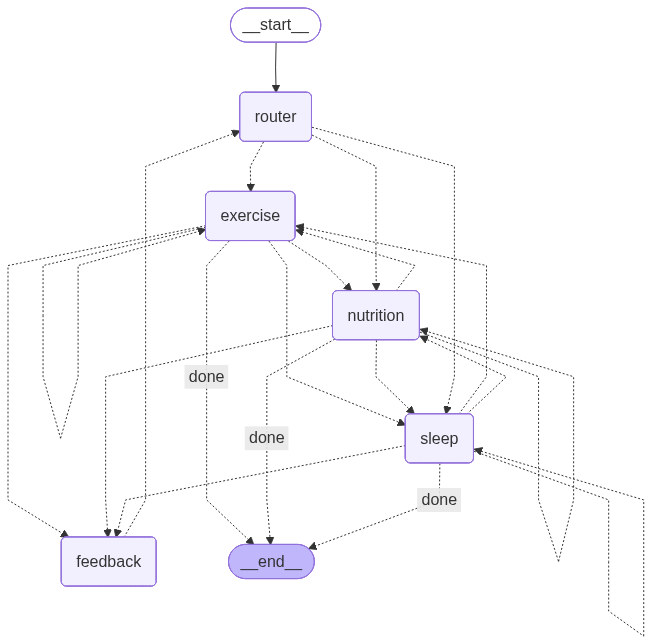

In [44]:
# Visualize the handoff graph
try:
    from IPython.display import display, Image
    display(Image(unified_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("\nGraph structure:")
    print(unified_graph.get_graph().draw_ascii())

In [ ]:

# Test the unified assistant
import uuid
config = {"configurable": {"thread_id": uuid.uuid4()}}
print_memory_report(store, config["configurable"]["thread_id"])

response = unified_graph.invoke(
    {
        "messages": [HumanMessage(content="can you give me an exercise, nutrition and sleep plan for the next 3 months?")],
        "user_id": "user_sarah",  # Sarah has a bad knee in her profile!
        "feedback": ""
    },
    config
)
print_memory_report(store, config["configurable"]["thread_id"])

# Print all messages in the conversation
print("\n" + "="*60)
print("CONVERSATION HISTORY")
print("="*60)
for i, msg in enumerate(response['messages']):
    msg_type = type(msg).__name__.replace("Message", "")
    name = getattr(msg, 'name', None)
    label = f"{msg_type}" + (f" [{name}]" if name else "")
    print(f"\n[{i+1}] {label}:")
    print("-" * 40)
    print(msg.content[:500] + "..." if len(msg.content) > 500 else msg.content)
print("\n" + "="*60)


MEMORY STATE REPORT
User Profile:
No profile stored.
No instructions found for exercise
No instructions found for nutrition
No instructions found for sleep
No episodes found for exercise
No episodes found for nutrition
No episodes found for sleep
Namespace counts: {'profile': 0, 'preferences': 0, 'instructions': 0, 'episodes': 0}

RouterInitial routing to: nutrition
[NUTRITION Agent] Processing...
[NUTRITION] Handing off to exercise: The question involves creating an exercise plan.
[EXERCISE Agent] Processing...
[EXERCISE] Handing off to nutrition: The question involves creating a nutrition plan.
[NUTRITION Agent] Processing...
[NUTRITION] Handing off to exercise: The question involves creating an exercise plan.
[EXERCISE Agent] Processing...
[EXERCISE] Handing off to nutrition: The question involves creating a nutrition plan.
[NUTRITION Agent] Processing...
[NUTRITION] Handing off to exercise: The question involves creating an exercise plan.
[EXERCISE Agent] Processing...
[EXERCISE] 

In [ ]:
# Follow-up question (tests short-term memory)
response = unified_graph.invoke(
    {
        "messages": [HumanMessage(content="Can you show me how to do the first one?")],
        "user_id": "user_sarah",
        "feedback": ""
    },
    config  # Same thread
)

print("User: Can you show me how to do the first one?")
print(f"\nAssistant: {response['messages'][-1].content}")
print("\nNotice: The agent remembers the context from the previous message!")

### Advanced Build Implementation Notes
* I went a little TDD on this one, writing out the test cases first in order to make sure I would be able to understand the goal, and when things worked. This ensured I had the state machine fully understood.

---
## Summary

In this session, we explored the **5 memory types** from the CoALA framework:

| Memory Type | LangGraph Component | Scope | Wellness Use Case |
|-------------|---------------------|-------|-------------------|
| **Short-term** | `MemorySaver` + `thread_id` | Within thread | Current consultation |
| **Long-term** | `InMemoryStore` + namespaces | Across threads | User profile, goals |
| **Semantic** | Store + embeddings + `search()` | Across threads | Knowledge retrieval |
| **Episodic** | Store + few-shot examples | Across threads | Past successful interactions |
| **Procedural** | Store + self-reflection | Across threads | Self-improving instructions |

### Key Takeaways:

1. **Memory transforms chatbots into assistants** - Persistence enables personalization
2. **Different memory types serve different purposes** - Choose based on your use case
3. **Context management is critical** - Trim and summarize to stay within limits
4. **Episodic memory enables learning** - Show, don't just tell
5. **Procedural memory enables adaptation** - Agents can improve themselves

### Production Considerations:

- Use `PostgresSaver` instead of `MemorySaver` for persistent checkpoints
- Use `PostgresStore` instead of `InMemoryStore` for persistent long-term memory
- Consider TTL (Time-to-Live) policies for automatic memory cleanup
- Implement proper access controls for user data

### Further Reading:

- [LangGraph Memory Documentation](https://langchain-ai.github.io/langgraph/concepts/memory/)
- [CoALA Paper](https://arxiv.org/abs/2309.02427) - Cognitive Architectures for Language Agents
- [LangGraph Platform](https://docs.langchain.com/langgraph-platform/) - Managed infrastructure for production